# Data Aggregation and Statistical Power

Julian Hsu

30-mar-2023

**2023-jun-02**: commenting and documentation updates.

The purpose of this script is to understand how statistical power of an experiment depends on (1) experiment duration and (2) how we aggregate data. We will think about these scenarios in the context of panel data, where we track users over time.

### Experiment Duration
One common way to increase the statistical power of an experiment is to run the experiment for longer. Assuming that the sample size is the same, we can extend the experiment duration to collect more trend data for each unit. However, depending on how unit-specific and time-specific noise there is, collecting more data may not actually increase power.

Another common way to increase power is to increase the sample size by running the experiment longer. Having a longer online experiment allows more users to enter - think about extending a marketing campaign so that more users get to see it. This is interesting as there could be selection in which types of customers are likely to see the experiment first, but we will ignore that here. 


### Aggregating Data
In cases where there is a lot of unit-level variation or noise, we may choose to aggregate them to get a clearer signal at the cost of a lower sample size. For example, rather than studying individual customers, we can study customer segment-level metrics. This aggregation also extends to aggregating over time (ie from daily to weekly or monthly), which is what we will study in this script. 


### Soundbyte Summary
Update: 21-apr-2023
**Hazards from Aggregating Data**: Often we aggregate daily-level data in order to decrease statistical noise, reduce our computational cost, or both. I show below that aggregating your data into larger time buckets can bias your experimental result, and it is not offset by increasing your precision (a lower standard error). If we are interested in looking at the average daily impact, we should keep our data at that level rather than calculcating a weekly impact and dividing by 7. You can find the full notebook here, as well as extra results on how the bias from aggregation is larger when you have correlated outcomes over time. 


### Model Setup

For our examples, we will generate synthetic panel data where we can change how much explainable variation there is versus unexplained variation.

Specifically, we are going model outcomes $y_{it}$ as:

$$y_{it} = \alpha y_{i,t-1} + \beta X_{it} + \gamma W_{it} + \nu_i + \tau_t + \epsilon_{it} $$

Where $\alpha$ tells us how auto-regressive the series is. We will set $\alpha=0$ for many simulations for simplicity.

Where $X_{it}$ has low variance, we have less explainable noise, and as $X_{it}$ variance increases (at an extreme it is sparse), we can allow more explainable noise.

Where $\gamma$ is our treatment effect of interest.

Where $\nu_i$ is unit-level fixed effect and $\tau_t$ is a time fixed effect.

Where $\epsilon_{it} \sim N(0,\sigma)$ as $\sigma$ increases we have more unexplainable noise. We can get even crazier and say that $\epsilon_{it} = h(\epsilon*_{it}), \epsilon*_{it} \sim N(0,\sigma)$ where $h()$ can be a censoring or top-coding function to create uneven variation in noise.



In [27]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels.panel import PanelOLS


In [2]:
def dgp(N=None, ## How many observations
        preT=None, ## How many pre-treatment time periods
        pstT=None, ## How many post-treatment time periods
        X_var=None, ## what is the variance in X
        ar=0.50, ## AR strength
        atet=1, ## Treatment effect
        error_std=None ## How much idiosyncractic error there is
       ):
    '''
    We predefine how many of the "mini time periods" there are within each time period. For example, we can say that
    each week time period is composed of seven day periods inside each week. We do this to make it easier to have
    separate time-period and "mini-time-period" fixed effects and trends.
    '''
    micro_periods = 10
    ## Create a panel dataset over all the "mini-time-periods"
    totalT = (preT+pstT)*micro_periods
    aggT =0
    ## Iteratively generate each time period
    for t in range(totalT):  
        ## First determine the pre-period outcome to allow an auto-regression structure
        if t==0:
            df=pd.DataFrame()
            ## Unit Fixed Effects
            unit_effect = np.random.uniform(-1,1,N)
            
            ## Define the treatment units
            treated_unit = np.arange(N) < 1
            prey=np.zeros(N)
        else:
            prey=df.iloc[-1*N:]['y']
            
        ## Second determine the period (NOT "mini-time-period") fixed effect
        if t%micro_periods==0:
#             aggt_effect = np.random.uniform(-1,1,N)
            aggt_effect=0
            aggT+=1
        else:
            pass
        ## Third, generate covariates 
        X= np.random.normal(0,X_var, N) * np.random.choice(2,N,p=[0.95,0.05])        
        
        ## Fourth, determine which unit/time periods are both in the treated unit list and post-treatment time period
        W= ( (t>=preT*micro_periods)*(treated_unit) ).astype(float)
        post= float(t>=preT*micro_periods)
        
        ## Fifth, determine the mini-time-period fixed effect
        t_effect= np.random.uniform(-1,1,N)
        
        ## Sixth, construct y
        y = ar*prey+X + atet*W + t_effect + unit_effect + aggt_effect+np.random.normal(0,error_std,N)
        entry = pd.DataFrame(data={'unitid':np.arange(N),
                                  't':t,
                                    'aggT':aggT,
                                  'X':X,
                                  'W':W,
                                   'post':post,
                                  'y':y})
        df = pd.concat([df,entry])
    return df

In [3]:
'''
Code up a DiD functio using the PanelOLS function.

'''

def did_twfe(data=None, lag=False, aggstat='mean'):
    try:
        data.set_index(['unitid','t'],inplace=True)
    except:
        pass
    if lag==False:
        XX=sm.add_constant(data[['X','W']])
    else:
        XX=sm.add_constant(pd.concat([data[['X','W']],data.groupby(['unitid'])['y'].shift() ],axis=1) )
    # Model using "mini-time-periods" as the time units
    m = PanelOLS(dependent=data['y'],
                 exog=XX,
                 entity_effects=True,
                 time_effects=True)
    res=m.fit()    
    
    ## Model using the time periods as the time units.
    ## We default to taking the average of covariates and outcome over the time periods.
    data.reset_index(inplace=True)
    dg=data.groupby(['unitid','aggT']).agg(X=('X',aggstat),
                                         W=('W','max'),
                                         y=('y',aggstat))
    if lag==False:
        XX=sm.add_constant(dg[['X','W']])
    else:
        XX=sm.add_constant(pd.concat([dg[['X','W']],dg.groupby(['unitid'])['y'].shift() ],axis=1) )    
    mg = PanelOLS(dependent=dg['y'],
                 exog=XX,
                 entity_effects=True,
                 time_effects=True)
    resg=mg.fit()    
    
    return pd.DataFrame(index=[0],data={'atet_indiv':res.params['W'],
                      'se_indiv':res.std_errors['W'],
                      'atet_agg':resg.params['W'],
                      'se_agg':resg.std_errors['W']})

In [4]:
df = dgp(N=30,preT=5,ar=0,pstT=3,atet=2, X_var=1,error_std=1)
twfe_result = did_twfe(data=df, lag=True, aggstat='mean')
display(twfe_result)

C:\Users\tarob\anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\tarob\anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


atet_indiv  se_indiv  atet_agg    se_agg
0    2.131318  0.275038  2.418496  0.272917

### Simulation Performance
I want to see how performance and ability to estimate the ATET and standard errors vary over:
1. The variation in the idiosyncratic errors: (`es_list`)
2. How many post periods we allow: (`post_list`)
3. The strength of the AR relationship: (`ar_list`)

We will also study how these results vary over using the "mini time periods" and time periods.

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
es_list= [0.05, 1,5,10]
post_list=[2,5,10]
ar_list = [0,0.10,0.50,0.75]

In [7]:
df_r=pd.DataFrame()
atet_=2
for pt in post_list:
    for pr in post_list:
        for es in es_list:
            for ar_ in ar_list:
                for s in range(50):
                    df = dgp(N=100,preT=pr,ar=ar_,pstT=pt,atet=atet_, X_var=0.25,error_std=es)
                    twfe_result = did_twfe(data=df, lag=True)
                    twfe_result['preT']=pr
                    twfe_result['pstT']=pt
                    twfe_result['sim']=s
                    twfe_result['ar'] = ar_
                    twfe_result['gt_atet']=atet_
                    twfe_result['error_std']=es
                    twfe_result['diff_indiv'] = twfe_result['atet_indiv'] - twfe_result['gt_atet']
                    twfe_result['diff_indiv_mape'] = twfe_result['diff_indiv']/twfe_result['gt_atet']
                    twfe_result['diff_agg'] = twfe_result['atet_agg'] - twfe_result['gt_atet']
                    twfe_result['diff_agg_mape'] = twfe_result['diff_agg']/twfe_result['gt_atet']        
                    df_r = pd.concat([df_r, twfe_result])

In [14]:

df_rg=df_r.groupby(['pstT','preT','ar','gt_atet','error_std']).mean()
df_rg.reset_index(inplace=True)

In [17]:
df_rg.groupby('error_std')[['diff_indiv_mape','diff_agg_mape','se_indiv','se_agg']].mean()

diff_indiv_mape  diff_agg_mape  se_indiv    se_agg
error_std                                                    
0.05              0.029241       0.901313  0.136101  0.280752
0.15              0.031702       0.904153  0.139890  0.287979
0.50              0.027267       0.909720  0.177262  0.361473
0.85              0.032176       0.917232  0.236532  0.477192

In [15]:
display(
    pd.pivot_table(df_rg, columns=['preT'], index=['pstT'], 
                   values=['diff_indiv_mape','diff_agg_mape','se_indiv','se_agg'], aggfunc=np.mean )
)

diff_agg_mape                     diff_indiv_mape                      \
preT            2         5         10              2         5         10   
pstT                                                                         
2         1.003377  0.893647  0.827161        0.067511  0.036891  0.018887   
5         0.996397  0.930994  0.866742        0.042933  0.025349  0.016896   
10        0.917518  0.877836  0.859270        0.029251  0.015700  0.017450   

        se_agg                      se_indiv                      
preT        2         5         10        2         5         10  
pstT                                                              
2     0.506072  0.368575  0.333125  0.244011  0.201259  0.184904  
5     0.474931  0.300593  0.249724  0.204983  0.153637  0.132271  
10    0.455248  0.267345  0.211028  0.189343  0.133048  0.108560

In [ ]:
to_plt=pd.pivot_table(df_r.loc[df_r['ar']==0], columns='pstT', index='preT', values=['diff_indiv_mape'])

sns.heatmap(to_plt)


In [20]:
display(
    pd.pivot_table(df_rg, columns=['ar'], index=['gt_atet'], 
                   values=['diff_indiv_mape','diff_agg_mape','se_indiv','se_agg'], aggfunc=np.mean )
)

diff_agg_mape                               diff_indiv_mape            \
ar               0.00      0.10      0.50      0.75            0.00      0.10   
gt_atet                                                                         
2            0.075502  0.183613  0.995225  2.378079        0.008334  0.013452   

                               se_agg                                se_indiv  \
ar           0.50      0.75      0.00      0.10      0.50      0.75      0.00   
gt_atet                                                                         
2        0.032538  0.066062  0.195658  0.215628  0.364504  0.631606  0.170338   

                                       
ar           0.10      0.50      0.75  
gt_atet                                
2        0.170597  0.172678  0.176172

We want to study how the bias and the standard error changes as:
1. We increase the number of post periods; 
2. We increase the number of pre periods;
3. (Optional) As the AR relationship grows stronger. The previous analyses assume AR = 0

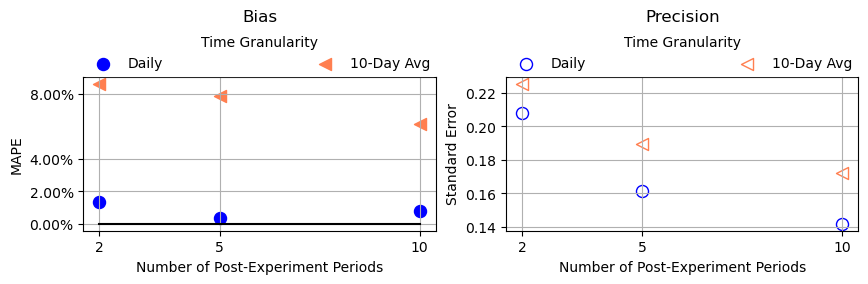

<Figure size 640x480 with 0 Axes>

In [99]:
to_plt = df_r.loc[df_r['ar']==0].groupby(['pstT'])[['diff_indiv_mape','diff_agg_mape','se_indiv','se_agg']].mean().reset_index()

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,2))
ax[0].scatter(to_plt['pstT'],
           to_plt['diff_indiv_mape'], s=75, color='blue', label='Daily')
ax[0].scatter(to_plt['pstT'],
           to_plt['diff_agg_mape'], s=75, marker='<', color='coral', label='10-Day Avg')
ax[0].plot( to_plt['pstT'], np.zeros(len(to_plt['pstT'])), color='black')
ax[0].set_xticks(to_plt['pstT'])
ax[0].set_yticks( [0,0.02,0.04,0.08], labels=['{0:2.2f}%'.format(e*100) for e in [0,0.02,0.04,0.08] ] )
ax[0].set_ylabel('MAPE')
ax[0].set_xlabel('Number of Post-Experiment Periods')
ax[0].legend(bbox_to_anchor=(0., 1.005, 1., .102), loc='lower left', ncol=2,title='Time Granularity',
                      mode="expand", borderaxespad=0., edgecolor='white')
ax[0].set_title('Bias', pad=40)
ax[0].grid()

ax[1].scatter(to_plt['pstT'], 
           to_plt['se_indiv'], s=75, edgecolor='blue', facecolor='white', label='Daily')
ax[1].scatter(to_plt['pstT'],
           to_plt['se_agg'], s=75, marker='<', edgecolor='coral', facecolor='white', label='10-Day Avg')
ax[1].set_xticks(to_plt['pstT'])
ax[1].set_ylabel('Standard Error')
ax[1].set_xlabel('Number of Post-Experiment Periods')
ax[1].legend(bbox_to_anchor=(0., 1.005, 1., .102), loc='lower left', ncol=2,title='Time Granularity',
                      mode="expand", borderaxespad=0, edgecolor='white')
ax[1].set_title('Precision', pad=40)
ax[1].grid()

plt.show()
plt.tight_layout()



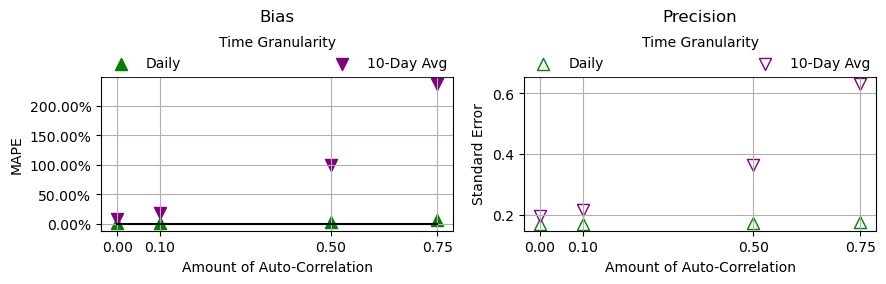

<Figure size 640x480 with 0 Axes>

In [104]:
to_plt = df_r.groupby(['ar'])[['diff_indiv_mape','diff_agg_mape','se_indiv','se_agg']].mean().reset_index()

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,2))
ax[0].scatter(to_plt['ar'],
           to_plt['diff_indiv_mape'], s=75,  marker='^', color='green', label='Daily')
ax[0].scatter(to_plt['ar'],
           to_plt['diff_agg_mape'], s=75, marker='v', color='purple', label='10-Day Avg')
ax[0].plot( to_plt['ar'], np.zeros(len(to_plt['ar'])), color='black')
ax[0].set_xticks(to_plt['ar'])
ax[0].set_yticks( [0,0.50,1,1.5,2], labels=['{0:2.2f}%'.format(e*100) for e in  [0,0.50,1,1.5,2] ] )
ax[0].set_ylabel('MAPE')
ax[0].set_xlabel('Amount of Auto-Correlation')
ax[0].legend(bbox_to_anchor=(0., 1.005, 1., .102), loc='lower left', ncol=2,title='Time Granularity',
                      mode="expand", borderaxespad=0., edgecolor='white')
ax[0].set_title('Bias', pad=40)
ax[0].grid()

ax[1].scatter(to_plt['ar'], 
           to_plt['se_indiv'], s=75, marker='^', edgecolor='green', facecolor='white', label='Daily')
ax[1].scatter(to_plt['ar'],
           to_plt['se_agg'], s=75, marker='v', edgecolor='purple', facecolor='white', label='10-Day Avg')
ax[1].set_xticks(to_plt['ar'])
ax[1].set_ylabel('Standard Error')
ax[1].set_xlabel('Amount of Auto-Correlation')
ax[1].legend(bbox_to_anchor=(0., 1.005, 1., .102), loc='lower left', ncol=2,title='Time Granularity',
                      mode="expand", borderaxespad=0, edgecolor='white')
ax[1].set_title('Precision', pad=40)
ax[1].grid()

plt.show()
plt.tight_layout()

